### Tugas Akhir Pengolahan Citra Digital dan Visi Komputer

**Real-time Facial Emotion Recognition**

<hr>

Anggota Kelompok:
1. Anda Bagas Aprianto (215150200111021)

2. Achmad Galih Wicaksana Putra (215150207111028)

#### 1. Import Libraries dan Modules

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import Label, Button, Frame
from PIL import Image, ImageTk
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img

#### 2. Data Preparation

In [ ]:
# Direktori untuk dataset pelatihan dan pengujian
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [ ]:
# Fungsi untuk membuat dataframe dari direktori dataset
def create_dataframe(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        for image_name in os.listdir(os.path.join(directory, label)):
            image_paths.append(os.path.join(directory, label, image_name))
            labels.append(label)
        print(f"Label {label} selesai.")
    return image_paths, labels

In [ ]:
# Membuat DataFrame untuk data pelatihan
train_df = pd.DataFrame()
train_df['image'], train_df['label'] = create_dataframe(TRAIN_DIR)
print(train_df)

In [ ]:
# Membuat DataFrame untuk data pengujian
test_df = pd.DataFrame()
test_df['image'], test_df['label'] = create_dataframe(TEST_DIR)
print(test_df)

#### 3. Data Preprocessing

In [ ]:
# Fungsi untuk ekstraksi fitur gambar
def extract_features(image_paths):
    features = []
    for image_path in tqdm(image_paths):
        img = load_img(image_path, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
# Ekstraksi fitur dari data pelatihan dan pengujian
train_features = extract_features(train_df['image'])
test_features = extract_features(test_df['image'])

In [ ]:
# Normalisasi fitur gambar
x_train = train_features / 255.0
x_test = test_features / 255.0

In [ ]:
# Label encoding untuk target
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])
y_train = label_encoder.transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Konversi label ke format one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

#### 4. Building the Neural Network Model

In [ ]:
# Membuat model sequential
model = Sequential()

# Lapisan konvolusi pertama
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Lapisan konvolusi kedua
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Lapisan konvolusi ketiga
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Lapisan konvolusi keempat
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Lapisan flatten untuk mengubah matriks 2D menjadi vektor 1D
model.add(Flatten())

# Lapisan fully connected pertama
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

# Lapisan fully connected kedua
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Lapisan output
model.add(Dense(7, activation='softmax'))

# Kompilasi model dengan optimizer Adam, loss categorical crossentropy, dan metrik akurasi
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model.summary()

#### 5. Training and Loading the Model

In [ ]:
# Melatih model dengan data pelatihan
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

In [ ]:
# Menyimpan arsitektur dan bobot model
model_json = model.to_json()
with open("model.json", 'w') as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [2]:
# Membaca model yang sudah dilatih
with open("model.json", "r") as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights("model.h5")

#### 6. Making Predictions on Test Images

In [3]:
# Daftar label untuk klasifikasi emosi
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Fungsi untuk ekstraksi fitur dari gambar tunggal
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale')
    feature = np.array(img)
    feature = feature.reshape(1, 48, 48, 1)
    return feature / 255.0

Gambar asli memiliki label: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Prediksi model: angry


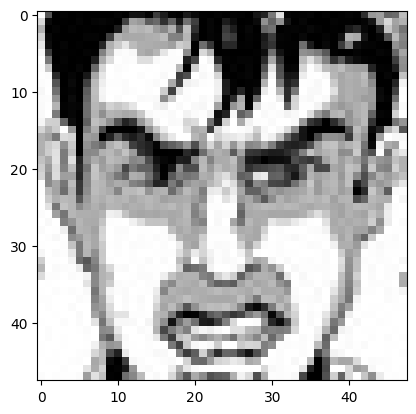

In [4]:
# Tes prediksi pada sebuah gambar berekspresi marah
print("Gambar asli memiliki label: angry")
img = preprocess_image('images/test/angry/38.jpg')
prediction = model.predict(img)
predicted_label = labels[prediction.argmax()]
print(f"Prediksi model: {predicted_label}")
plt.imshow(img.reshape(48, 48), cmap='gray')

Gambar asli memiliki label: disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Prediksi model: disgust


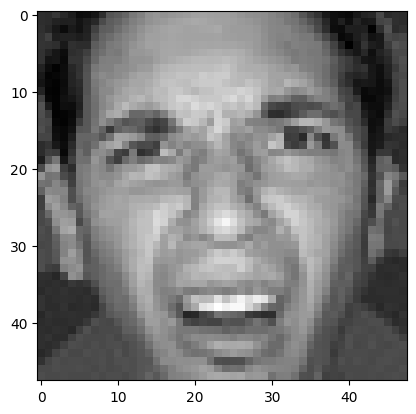

In [5]:
# Tes prediksi pada sebuah gambar berekspresi jijik
print("Gambar asli memiliki label: disgust")
img = preprocess_image('images/test/disgust/3101.jpg')
prediction = model.predict(img)
predicted_label = labels[prediction.argmax()]
print(f"Prediksi model: {predicted_label}")
plt.imshow(img.reshape(48, 48), cmap='gray')

Gambar asli memiliki label: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Prediksi model: fear


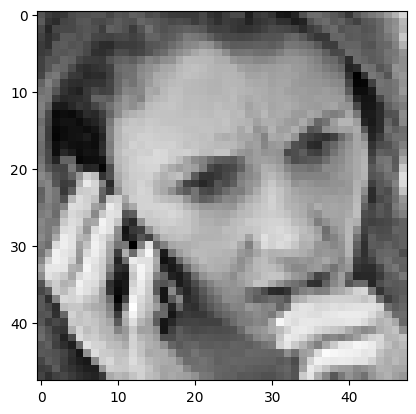

In [6]:
# Tes prediksi pada sebuah gambar berekspresi takut
print("Gambar asli memiliki label: fear")
img = preprocess_image('images/test/fear/258.jpg')
prediction = model.predict(img)
predicted_label = labels[prediction.argmax()]
print(f"Prediksi model: {predicted_label}")
plt.imshow(img.reshape(48, 48), cmap='gray')

Gambar asli memiliki label: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Prediksi model: happy


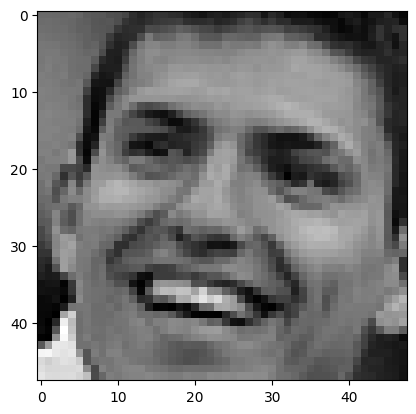

In [7]:
# Tes prediksi pada sebuah gambar berekspresi senang
print("Gambar asli memiliki label: happy")
img = preprocess_image('images/test/happy/325.jpg')
prediction = model.predict(img)
predicted_label = labels[prediction.argmax()]
print(f"Prediksi model: {predicted_label}")
plt.imshow(img.reshape(48, 48), cmap='gray')

Gambar asli memiliki label: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediksi model: neutral


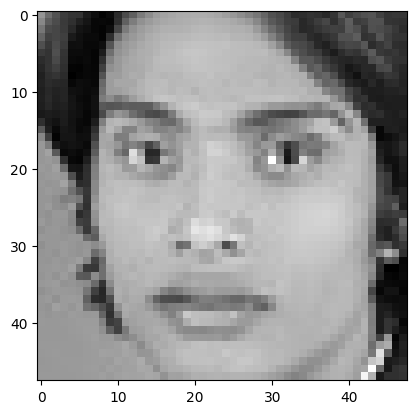

In [8]:
# Tes prediksi pada sebuah gambar berekspresi netral
print("Gambar asli memiliki label: neutral")
img = preprocess_image('images/test/neutral/35484.jpg')
prediction = model.predict(img)
predicted_label = labels[prediction.argmax()]
print(f"Prediksi model: {predicted_label}")
plt.imshow(img.reshape(48, 48), cmap='gray')

Gambar asli memiliki label: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediksi model: sad


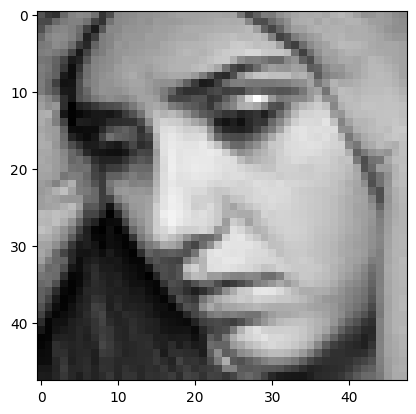

In [9]:
# Tes prediksi pada sebuah gambar berekspresi sedih
print("Gambar asli memiliki label: sad")
img = preprocess_image('images/test/sad/231.jpg')
prediction = model.predict(img)
predicted_label = labels[prediction.argmax()]
print(f"Prediksi model: {predicted_label}")
plt.imshow(img.reshape(48, 48), cmap='gray')

Gambar asli memiliki label: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Prediksi model: surprise


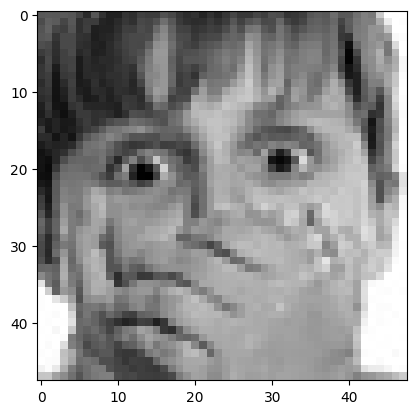

In [10]:
# Tes prediksi pada sebuah gambar berekspresi terkejut
print("Gambar asli memiliki label: surprise")
img = preprocess_image('images/test/surprise/1176.jpg')
prediction = model.predict(img)
predicted_label = labels[prediction.argmax()]
print(f"Prediksi model: {predicted_label}")
plt.imshow(img.reshape(48, 48), cmap='gray')

#### 7. Making the Model Real Time

In [11]:
# Menggunakan file Haar Cascade untuk deteksi wajah
haar_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_cascade_path)

In [12]:
# Fungsi untuk ekstraksi fitur dari wajah
def extract_face_features(face_image):
    face_array = np.array(face_image)
    face_array = face_array.reshape(1, 48, 48, 1)
    return face_array / 255.0

In [ ]:
# Buka kamera
camera = cv2.VideoCapture(0)

# Daftar label untuk emosi
emotion_labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

while True:
    # Membaca frame dari kamera
    ret, frame = camera.read()
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    detected_faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.2, minNeighbors=5)

    for (x, y, w, h) in detected_faces:
        # Ambil ROI wajah
        face_roi = gray_frame[y:y + h, x:x + w]

        # Gambar kotak di sekitar wajah
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Ubah ukuran wajah ke ukuran 48x48
        resized_face = cv2.resize(face_roi, (48, 48))

        # Ekstrak fitur dan prediksi emosi
        face_features = extract_face_features(resized_face)
        prediction = model.predict(face_features)
        predicted_label_idx = prediction.argmax()
        emotion = emotion_labels[predicted_label_idx]

        # Hitung confidence level
        confidence_level = prediction[0][predicted_label_idx] * 100

        # Tampilkan emosi di atas kotak wajah
        cv2.putText(frame, f'{emotion} ({confidence_level:.2f}%)', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Tampilkan frame
    cv2.imshow("Real-time Facial Emotion Recognition", frame)

    # Tekan tombol ESC untuk keluar
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Bebaskan kamera dan tutup jendela
camera.release()
cv2.destroyAllWindows()

#### 8. Real-time Facial Emotion Recognition with GUI

In [11]:
# Fungsi untuk membuka model
def load_model():
    with open("model.json", "r") as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
    model.load_weights("model.h5")
    return model

# Fungsi untuk menampilkan frame dari kamera dan mendeteksi emosi
def show_frame():
    # Baca frame dari kamera
    ret, frame = camera.read()
    if not ret:
        return
    
    # Konversi ke grayscale untuk deteksi wajah
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.2, minNeighbors=5)

    # Proses setiap wajah yang terdeteksi
    for (x, y, w, h) in detected_faces:
        face_roi = gray_frame[y:y + h, x:x + w]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Resize wajah untuk model
        resized_face = cv2.resize(face_roi, (48, 48))
        face_features = extract_face_features(resized_face)
        prediction = model.predict(face_features)
        predicted_label_idx = prediction.argmax()
        emotion = emotion_labels[predicted_label_idx]
        confidence_level = prediction[0][predicted_label_idx] * 100

        # Tampilkan emosi pada frame
        cv2.putText(frame, f'{emotion} ({confidence_level:.2f}%)', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Konversi frame ke format yang dapat ditampilkan pada tkinter
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(frame_rgb)
    image = ImageTk.PhotoImage(image)
    
    # Update label dengan gambar terbaru
    label_image.config(image=image)
    label_image.image = image
    
    # Lanjutkan menampilkan frame
    if camera_on:
        window.after(10, show_frame)

# Fungsi untuk memulai kamera
def start_camera():
    global camera_on
    camera_on = True
    start_button.config(state=tk.DISABLED)
    stop_button.config(state=tk.NORMAL)
    exit_button.config(state=tk.DISABLED)
    show_frame()

# Fungsi untuk berhenti menampilkan kamera
def stop_camera():
    global camera_on
    camera_on = False
    start_button.config(state=tk.NORMAL)
    stop_button.config(state=tk.DISABLED)
    exit_button.config(state=tk.NORMAL)

    # Menyembunyikan layar kamera setelah stop
    label_image.config(image='')

# Fungsi untuk keluar dari program (menutup semua dan mematikan kamera)
def exit_program():
    global camera_on
    camera_on = False
    camera.release()
    window.quit()

# Inisialisasi model dan cascade wajah
model = load_model()
haar_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_cascade_path)

# Fungsi untuk ekstraksi fitur dari wajah
def extract_face_features(face_image):
    face_array = np.array(face_image)
    face_array = face_array.reshape(1, 48, 48, 1)
    return face_array / 255.0

# Daftar label untuk emosi
emotion_labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

# Membuka kamera
camera = cv2.VideoCapture(0)

# Inisialisasi Tkinter
window = tk.Tk()
window.title("Real-time Facial Emotion Recognition")

# Set ukuran jendela
window.geometry("800x600")

# Ubah latar belakang jendela menjadi putih
window.config(bg="white")

# Frame untuk konten utama
main_frame = Frame(window, bg="white")
main_frame.pack(padx=20, pady=20, expand=True, fill=tk.BOTH)

# Label untuk menampilkan video
label_image = Label(main_frame)
label_image.pack(pady=20)

# Label Judul Aplikasi
title_label = Label(main_frame, text="Real-time Facial Emotion Recognition", font=("Helvetica", 18, 'bold'), fg="black", bg="white")
title_label.pack(pady=20)

# Frame untuk tombol
button_frame = Frame(main_frame, bg="white")
button_frame.pack(pady=10)

# Tombol start
start_button = Button(button_frame, text="Start Camera", width=20, height=2, command=start_camera, font=("Helvetica", 14), bg="#27AE60", fg="white", relief="raised")
start_button.grid(row=0, column=0, padx=10)

# Tombol stop
stop_button = Button(button_frame, text="Stop Camera", width=20, height=2, command=stop_camera, font=("Helvetica", 14), bg="#E74C3C", fg="white", relief="raised", state=tk.DISABLED)
stop_button.grid(row=0, column=1, padx=10)

# Tombol exit
exit_button = Button(button_frame, text="Exit", width=20, height=2, command=exit_program, font=("Helvetica", 14), bg="#F1C40F", fg="black", relief="raised")
exit_button.grid(row=1, column=0, columnspan=2, pady=20)

# Variabel untuk menandakan status kamera
camera_on = False

# Menjalankan aplikasi Tkinter
window.protocol("WM_DELETE_WINDOW", exit_program)  # Menangani keluar dengan tombol X
window.mainloop()

# Melepaskan kamera setelah keluar
camera.release()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
